In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# These files are from th .xlsx file from Jin-Si on April 5.
# They replace the files from Jin-Si on March 31.
# area_csv = 'D:/crs/proj/2023_NCB_recovery/NCB_Pond_Recovery_10_area.csv'
# perim_csv = 'D:/crs/proj/2023_NCB_recovery/NCB_Pond_Recovery_10_perim.csv'
# I saved the sheets as csv files and removed the first of two header rows
area_csv = 'D:/crs/proj/2023_NCB_recovery/NCB_Pond_Recovery_Metrics_area.csv'
perim_csv = 'D:/crs/proj/2023_NCB_recovery/NCB_Pond_Recovery_Metrics_perimeter.csv'

#### Functions for converting to along- and cross-island coordinates

In [2]:
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r = np.sqrt(x**2 + y**2)
    az = np.degrees(np.arctan2(x, y))
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az


def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y


def UTM2Island(eutm, nutm, eoff=383520.0, noff=3860830.0, rot=42.0):
    """
    Convert UTM NAD83 Zone 18N easting, northing to N. Core Banks alongshore, cross-shore coordinates
    xisl, yisl = UTM2Island( eutm, nutm )
    Better to use values from the dict than defaults for translation/rotation values
    Defaults are associated with the dict read in from `small_island_box.yml`
    """
    [r, az] = pcoord(eutm-eoff, nutm-noff)
    az = az + rot
    [xisl,yisl] = xycoord(r,az)
    return xisl, yisl

#### Routine to convert datetime to decimal years (for fitting)

In [3]:
# long-winded way of changing dt to decimal years
# https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years
from datetime import datetime as datetime
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

#### Survey dates

In [4]:
dates =['2019-09-13',
         '2019-10-11', 
         '2019-11-26',
         '2020-02-08', 
         '2020-05-08', 
         '2020-08-02', 
         '2020-08-05', 
         '2020-09-28', 
         '2021-04-30', 
         '2021-06-15', 
         '2021-09-20', 
         '2022-10-19']
dt = pd.to_datetime(dates)

In [5]:
# read in the area file, extract data for main ponds (no sub pond)
dfa = pd.read_csv(area_csv)
area = dfa[dfa['Sub Pond'].isna()].iloc[:,6:18].values
nponds, ntimes = np.shape(area)

In [6]:
dfs = dfa.iloc[:,6:18].describe()
dfs

,2019_09,2019_10,2019_11,2020_02_08,2020_05_08,2020_08_02,2020_08_05,2020_09_28,2021_04_30,2021_06_15,2021_09_20,2022_10_19
count,83.000000,133.000000,205.000000,209.000000,188.000000,196.000000,184.000000,195.000000,186.000000,191.000000,191.000000,185.000000
mean,13228.209952,6648.233431,3248.133805,3045.873032,2734.568868,2457.797666,2640.442287,3046.952440,2162.407787,2171.398243,2371.778529,2394.462521
std,16770.384123,10318.788797,6419.618937,5650.101952,5378.356755,5011.676193,5318.097676,5668.243606,4445.390009,4658.485965,4981.762063,4966.604036
min,45.170518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1308.232804,466.581843,58.000000,92.680978,28.277901,23.586018,27.598797,122.929296,29.263903,20.794066,21.132133,23.209954
50%,7157.332135,3043.000000,584.848923,698.361084,359.997150,252.000000,369.133507,816.592750,270.282109,175.782432,167.055427,230.369119
75%,18224.568080,7989.553713,2595.064686,2490.457282,1959.773601,1812.052241,1767.978500,2283.534810,1602.986033,1422.271288,1581.978141,1570.154948
max,88843.655220,61841.469350,38807.492870,29120.705180,25531.755220,25644.294200,25430.983500,31707.075790,22762.831080,23411.680780,24942.555900,25256.827460


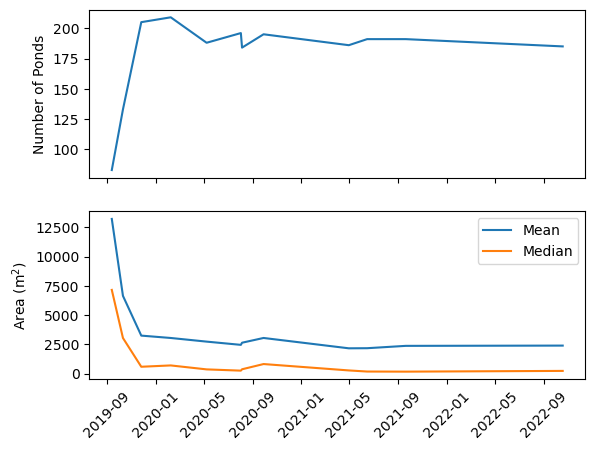

In [7]:
num_ponds = dfs.iloc[0,:].values
avg_area = dfs.iloc[1,:].values
med_area = dfs.iloc[5,:].values
max_area = dfs.iloc[7,:].values
fix, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(dt,num_ponds)
ax[0].set_ylabel('Number of Ponds')
ax[1].plot(dt,avg_area,label='Mean')
ax[1].plot(dt,med_area,label='Median')
ax[1].set_ylabel(r'Area (m$^2$)')
ax[1].legend()
_ = plt.xticks(rotation=45)

In [8]:
# read in the perimeter file, extract data for main ponds (no sub pond)
dfp = pd.read_csv(perim_csv)
perim = dfp[dfp['Sub Pond'].isna()].iloc[:,6:18].values
print(np.shape(perim))

(83, 12)


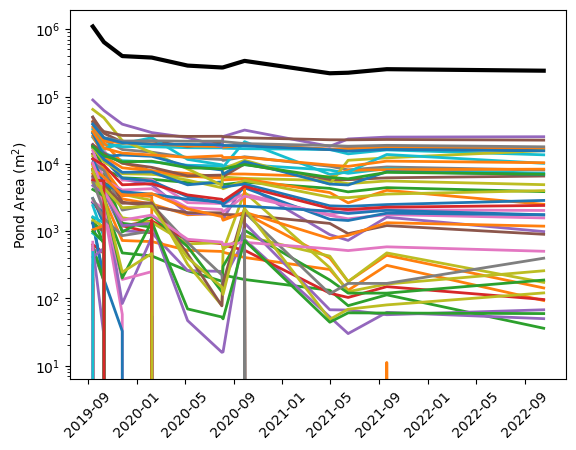

In [9]:
for i in range(nponds):
    plt.plot(dt, area[i,:],linewidth=2)
plt.plot(dt, np.nansum(area,0),'-k',linewidth=3)
plt.ylabel(r'Pond Area (m$^2$)')
plt.yscale('log')
_ = plt.xticks(rotation=45)

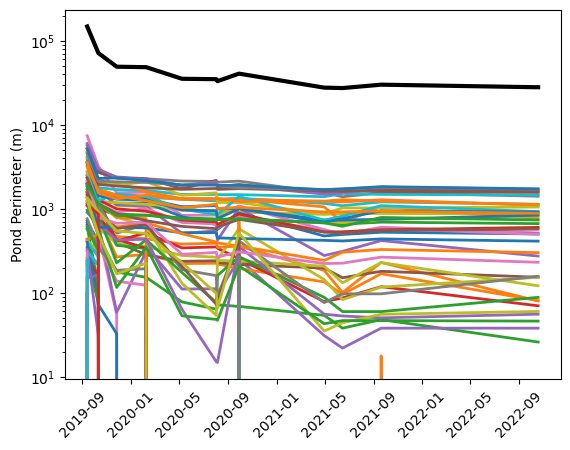

In [10]:
for i in range(nponds):
    plt.plot(dt, perim[i,:],linewidth=2)
plt.plot(dt, np.nansum(perim,0),'-k',linewidth=3)
plt.ylabel(r'Pond Perimeter (m)')
plt.yscale('log')
_ = plt.xticks(rotation=45)

C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_11760\1560745209.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(dt,area[i,:]/perim[i,:],linewidth=2)
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_11760\1560745209.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dt,area[i,:]/perim[i,:],linewidth=2)
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_11760\1560745209.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dt, np.nanmean(area/perim,0),'-k',linewidth=3)
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_11760\1560745209.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(dt, np.nanmean(area/perim,0),'-k',linewidth=3)


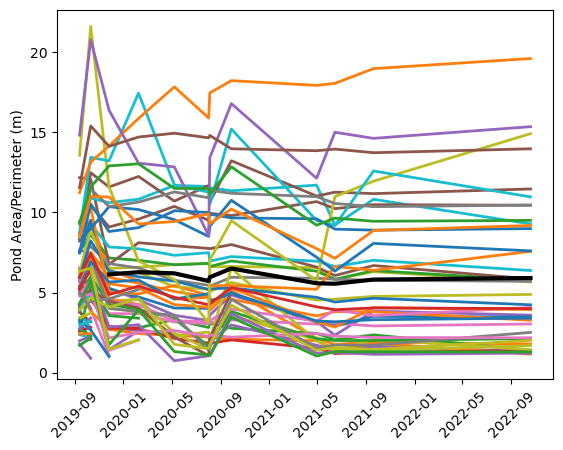

In [11]:
for i in range(nponds):
    plt.plot(dt,area[i,:]/perim[i,:],linewidth=2)
plt.plot(dt, np.nanmean(area/perim,0),'-k',linewidth=3)
plt.ylabel(r'Pond Area/Perimeter (m)')
_ = plt.xticks(rotation=45)

#### Convert dt to decimal year for regressions

In [12]:
yr = np.ones(len(dt))
for i, val in enumerate(dt):
    yr[i]=toYearFraction(val)
yr    

array([2019.69851598, 2019.77522831, 2019.90136986, 2020.10382514,
       2020.34961293, 2020.58458561, 2020.59278233, 2020.74032332,
       2021.32591324, 2021.45194064, 2021.71769406, 2022.79714612])

#### ... and export as .csv

In [13]:
pd.DataFrame(yr.round(decimals=3)).to_csv('decimal_survey_dates.csv',header=None, index=None)

In [14]:
print(np.log(0.5))

-0.6931471805599453


[-5.30230672e-01  1.08430097e+03]
3.6339408377662634


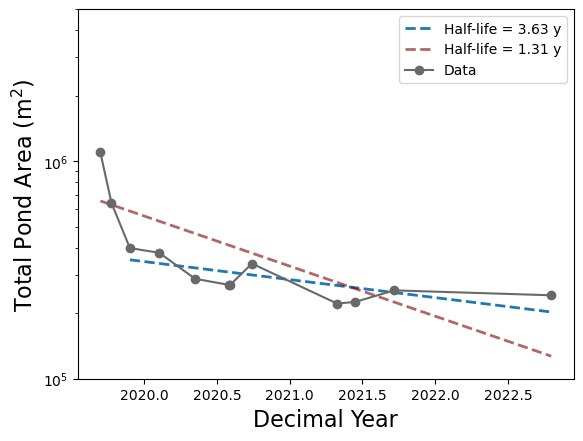

In [19]:
# fit area = log(Area) = a+bt
areat = np.nansum(area,0)
m = np.polyfit( yr, np.log(areat), 1, w=np.sqrt(areat))
print(m)
amod = np.exp(m[1]+m[0]*yr)
m_half = np.log(0.5)/m[0]
ts = (r'Half-life = ' + '{:.2f} y'.format(m_half) )
# omit first two datapoints
m2 = np.polyfit( yr[2:], np.log(areat[2:]), 1, w=np.sqrt(areat[2:]))
amod2 = np.exp(m2[1]+m2[0]*yr[2:])
m2_half = np.log(0.5)/m2[0]
ts2 = (r'Half-life = ' + '{:.2f} y'.format(m2_half) )
print(np.log(0.5)/m2[0])
plt.plot(yr[2:], amod2, '--', linewidth=2, label=ts2)

plt.plot(yr, amod, '--', linewidth=2, c= 'maroon', label=ts, alpha = .6)
plt.plot(yr, areat, '-o', label='Data', c='dimgray')
plt.yscale('log')
plt.ylim([1e5, .5e7])
plt.ylabel(r'Total Pond Area (m$^2$)',fontsize=16)
plt.xlabel('Decimal Year', fontsize=16)
plt.legend()
plt.savefig('D:/crs/proj/2023_NCB_recovery/pond_area_halflife.png', bbox_inches='tight', dpi = 200)

#### Calculate along-island coordinates

In [81]:
x = dfa[~dfa['X'].isna()].iloc[:,0].values
y = dfa[~dfa['Y'].isna()].iloc[:,1].values
xisle, yisle = UTM2Island(x, y)

In [94]:
X, Y = np.meshgrid(yr, xisle)
np.shape(area)

(83, 12)

#### Recalculate island coordinates including NaNs, to add to the Excel sheet

In [109]:
xall = dfa['X'].values
yall = dfa['Y'].values
pd.DataFrame((np.vstack((xall, yall)).T).round(decimals=2)).to_csv('islandXY.csv',header=None, index=None)

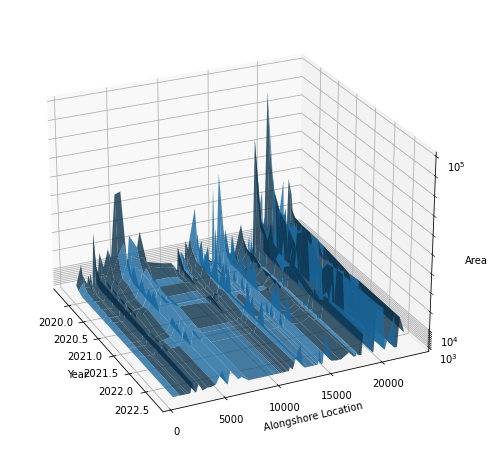

In [115]:
fig = plt.figure(figsize=(8,18))
ax = fig.add_subplot(projection='3d')

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
ax.plot_surface(X, Y, area, alpha=0.8)
ax.set_zscale('log')
ax.set_xlabel('Year')
ax.set_ylabel('Alongshore Location')
ax.set_zlabel('Area')
ax.set_zlim([1e3,1e5])
ax.view_init(elev=25,azim=-25)
# # On the y-axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)

plt.show()

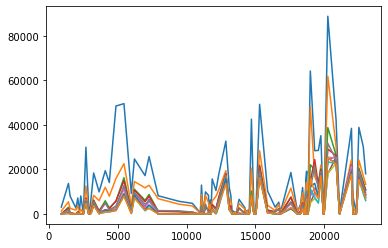

In [87]:
for i in range(12):
    plt.plot(xisle,area[:,i])
